#Preperation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

'Colab Notebooks'       DSAI544_Final	    'OOP Beginner to Pro'  'Salvador Dali Paintings'
'DSAI544 Assignments'  'ML Homework codes'  'PyTorch Bootcamp'


In [ ]:
!ls "/content/drive/My Drive/DSAI544_Final"

 data	   'DSAI544 Final Project.ipynb'   phase1_pretrained_weights.pth
 data.zip   __MACOSX			   split_dataset


In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/DSAI544_Final/data.zip'
# Path to extract the content (same folder as zip file)
extract_path = '/content/drive/My Drive/DSAI544_Final'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the folder after extraction
print("Contents of the folder after extraction:")
print(os.listdir(extract_path))

Contents of the folder after extraction:
['data.zip', '.ipynb_checkpoints', 'DSAI544 Final Project.ipynb', 'data', '__MACOSX']


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source and destination paths
source_path = "/content/drive/MyDrive/DSAI544_Final/data"
destination_base_path = "/content/drive/MyDrive/DSAI544_Final/split_dataset"

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure destination folders exist
os.makedirs(destination_base_path, exist_ok=True)
train_path = os.path.join(destination_base_path, "train")
val_path = os.path.join(destination_base_path, "validation")
test_path = os.path.join(destination_base_path, "test")
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate over each class folder
for class_name in os.listdir(source_path):
    class_dir = os.path.join(source_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Get all image files in the class folder
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split the images into train, validation, and test sets
    train_files, temp_files = train_test_split(image_files, test_size=(val_ratio + test_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Create class subdirectories in each split folder
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Move files to their respective split folders
    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_path, class_name, file))
    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_path, class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_path, class_name, file))

print("Dataset split into train, validation, and test sets successfully.")

Dataset split into train, validation, and test sets successfully.


In [ ]:
!pip install wandb

In [ ]:
!pip install pytorch-lightning
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade pillow torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.1 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights

import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

import wandb
from tqdm import tqdm

In [ ]:
!nvidia-smi

Tue Jan 14 09:45:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

#First Phase

##Pre-Training

In [ ]:
# Initialize WandB
wandb.finish()  # Close any previous runs
wandb.init(
    project="DSAI544-Final",
    name="1/Pre-training",
    config={
        "batch_size": 128,
        "learning_rate": 0.0005,
        "epochs": 20,
        "temperature": 0.5,
        "projection_dim": 256,
    }
)

# Load WandB config
config = wandb.config

# Set Tensor Core precision
torch.set_float32_matmul_precision('high')

# Data augmentations for SimCLR
transform_simclr = transforms.Compose([
    transforms.RandomResizedCrop(size=128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

# Dataset paths
train_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/train'
val_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/validation'

# Load datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform_simclr)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_simclr)

# DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=12
)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=12
)

# Define SimCLR model
class SimCLR(pl.LightningModule):
    def __init__(self, projection_dim, learning_rate, temperature):
        super(SimCLR, self).__init__()
        self.encoder = resnet18(weights=None)
        self.encoder.fc = nn.Identity()  # Remove classification head
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.temperature = temperature

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection(features)
        return F.normalize(projections, dim=1)

    def training_step(self, batch, batch_idx):
        images, _ = batch
        features = self(images)
        loss = self.nt_xent_loss(features)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, _ = batch
        features = self(images)
        val_loss = self.nt_xent_loss(features)
        self.log("val_loss", val_loss)
        return val_loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.learning_rate)

    def nt_xent_loss(self, features):
        batch_size = features.shape[0]
        labels = torch.arange(batch_size).to(features.device)
        similarity_matrix = torch.matmul(features, features.T)
        scaled_similarity = similarity_matrix / self.temperature
        loss = self.criterion(scaled_similarity, labels)
        return loss

# Instantiate model
model = SimCLR(
    projection_dim=config.projection_dim,
    learning_rate=config.learning_rate,
    temperature=config.temperature
)

# WandB logger
wandb_logger = WandbLogger(project="simclr-pretraining")

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="simclr-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=10, mode="min"
)

# Trainer
trainer = pl.Trainer(
    max_epochs=config.epochs,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Save the pre-trained model weights to Google Drive
torch.save(model.state_dict(), "/content/drive/MyDrive/DSAI544_Final/phase1_pretrained_weights.pth")

# Finish WandB session
wandb.finish()

NameError: name 'wandb' is not defined

##Fine-Tuning

In [ ]:
# Initialize WandB
wandb.finish()  # Close any previous runs
wandb.init(
    project="DSAI544-Final",
    name="1/Fine-tuning",
    config={
        "batch_size": 128,
        "learning_rate": 0.0001,
        "weight_decay": 1e-4,
        "epochs": 20,
        "lr_step_size": 5,
        "lr_gamma": 0.5,
    }
)

# Fetch configuration from WandB
config = wandb.config

# Data augmentations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset paths
train_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/train'
val_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/validation'

# Load datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
val_dataset = ImageFolder(root=val_data_dir, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# SimCLR model definition
class SimCLR(LightningModule):
    def __init__(self, projection_dim, temperature=0.5):
        super(SimCLR, self).__init__()
        self.encoder = resnet18(weights=None)
        self.encoder.fc = nn.Identity()  # Remove classification head
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.temperature = temperature

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection(features)
        return F.normalize(projections, dim=1)

    def nt_xent_loss(self, features):
        batch_size = features.shape[0]
        labels = torch.arange(batch_size).to(features.device)
        similarity_matrix = torch.matmul(features, features.T)
        scaled_similarity = similarity_matrix / self.temperature
        loss = self.criterion(scaled_similarity, labels)
        return loss

# Fine-tuning model
class FineTuningModel(LightningModule):
    def __init__(self, pretrained_model, num_classes, learning_rate, weight_decay, lr_step_size, lr_gamma):
        super(FineTuningModel, self).__init__()
        self.encoder = pretrained_model.encoder  # Use pre-trained encoder
        self.classifier = nn.Linear(512, num_classes)  # Add classification head
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.lr_step_size = lr_step_size
        self.lr_gamma = lr_gamma

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss)
        self.log("train_accuracy", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        val_loss = self.criterion(outputs, labels)
        val_acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", val_loss)
        self.log("val_accuracy", val_acc)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=self.lr_step_size, gamma=self.lr_gamma)
        return [optimizer], [scheduler]

# Initialize SimCLR model
pretrained_model = SimCLR(projection_dim=256, temperature=0.5)

# Load pre-trained weights
pretrained_weights_path = "/content/drive/MyDrive/DSAI544_Final/phase1_pretrained_weights.pth"
pretrained_model.load_state_dict(torch.load(pretrained_weights_path))
print("Pre-trained weights successfully loaded.")

# Initialize Fine-tuning model
fine_tune_model_phase1 = FineTuningModel(
    pretrained_model=pretrained_model,
    num_classes=10,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    lr_step_size=config.lr_step_size,
    lr_gamma=config.lr_gamma
)

# WandB logger
wandb_logger = WandbLogger(project="simclr-finetuning")

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="fine-tune-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=8, mode="min"
)

# Trainer
trainer = Trainer(
    max_epochs=config.epochs,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Train the model
trainer.fit(fine_tune_model_phase1, train_loader, val_loader)

# Finish WandB session
wandb.finish()

##Testing

In [ ]:
# Initialize WandB for test visualization
wandb.init(
    project="DSAI544-Final",
    name="1/Test Results Visualization"
)

# Test images directory (update to split dataset's test directory)
test_images_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/test'

# Transform for the test images (resize and normalization only, no augmentations)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Randomly select 10 test images from the test dataset
selected_images = []
for class_name in os.listdir(test_images_dir):
    class_dir = os.path.join(test_images_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        selected_images += [(class_name, os.path.join(class_dir, img)) for img in random.sample(image_files, 1)]

# Prepare test images and ground truth labels
test_images = []
true_labels = []
for class_name, img_path in selected_images:
    img = Image.open(img_path).convert("RGB")  # Ensure it's in RGB mode
    img = test_transform(img)
    test_images.append(img)
    true_labels.append(class_name)

# Stack images into a batch
test_images = torch.stack(test_images)  # Combine into a single batch
device = "cuda" if torch.cuda.is_available() else "cpu"
test_images = test_images.to(device)

# Set model to evaluation mode
fine_tune_model_phase1.to(device)
fine_tune_model_phase1.eval()

# Predict classes
with torch.no_grad():
    outputs = fine_tune_model_phase1(test_images)
    predicted_classes = outputs.argmax(dim=1).tolist()

# Map predicted class indices to class names
class_names = train_dataset.classes  # Use train dataset to map class names
predicted_labels = [class_names[idx] for idx in predicted_classes]

# Prepare WandB images
wandb_images = []
for true_label, predicted_label, img_path in zip(true_labels, predicted_labels, selected_images):
    img = Image.open(img_path[1])  # Load the image
    wandb_images.append(
        wandb.Image(img.resize((128, 128)), caption=f"True: {true_label}, Predicted: {predicted_label}")
    )

# Log all images to WandB
wandb.log({"Test Results": wandb_images})

# Display the images locally as well
plt.figure(figsize=(20, 10))
for i, (true_label, predicted_label, img_path) in enumerate(zip(true_labels, predicted_labels, selected_images)):
    plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
    img = Image.open(img_path[1])
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Finish WandB session
wandb.finish()

#Second Phase (Hyperparameter Tuning)

In [ ]:
# Initialize WandB
wandb.finish()  # Close any previous runs
wandb.init(
    project="DSAI544-Final",
    name="2/Fine Tuning-Optimized",
    config={
        "batch_size": 256,  # Larger batch size for stable gradients
        "learning_rate": 0.0005,  # Slightly higher learning rate
        "weight_decay": 1e-5,  # Reduced weight decay
        "epochs": 25,
        "dropout": 0.4,
        "label_smoothing": 0.2,
    }
)

# Fetch configuration from WandB
config = wandb.config

# Updated data augmentations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(120),  # Adding RandomCrop
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset paths
train_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/train'
val_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/validation'

# Load datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
val_dataset = ImageFolder(root=val_data_dir, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=8)

# Fine-tuning model
class FineTuningModel(LightningModule):
    def __init__(self, pretrained_model, num_classes, learning_rate, weight_decay):
        super(FineTuningModel, self).__init__()
        self.encoder = pretrained_model.encoder
        self.classifier = nn.Sequential(
            nn.Dropout(config.dropout),
            nn.Linear(512, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        val_loss = self.criterion(outputs, labels)
        val_acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_accuracy", val_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_accuracy"}}

# Initialize SimCLR pre-trained model
pretrained_model = SimCLR(projection_dim=256, temperature=0.5)

# Load pre-trained weights
pretrained_weights_path = "/content/drive/MyDrive/DSAI544_Final/phase1_pretrained_weights.pth"
pretrained_model.load_state_dict(torch.load(pretrained_weights_path))
print("Pre-trained weights successfully loaded.")

# Initialize fine-tuning model
fine_tune_model = FineTuningModel(
    pretrained_model=pretrained_model,
    num_classes=10,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay
)

# WandB logger
wandb_logger = WandbLogger(project="simclr-finetuning-aggressive")

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",
    dirpath="checkpoints",
    filename="fine-tune-{epoch:02d}-{val_accuracy:.2f}",
    save_top_k=3,
    mode="max",
)
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy", patience=7, mode="max"
)

# Trainer
trainer = Trainer(
    max_epochs=config.epochs,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    gradient_clip_val=1.0,
)

# Train the model
trainer.fit(fine_tune_model, train_loader, val_loader)

# Finish WandB session
wandb.finish()

<ipython-input-24-a22893e2d3bc>:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(pretrained_weights_path))
INFO:pytorch_lightnin

Pre-trained weights successfully loaded.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


#ResNet50 Pre-trained Weights

I initially aimed to use my own pre-trained SimCLR model for fine-tuning, but despite numerous attempts with different hyperparameters and data augmentations, I couldn’t achieve the desired validation accuracy. The results remained inconsistent and far from my goal, even after significant adjustments. After careful consideration, I decided to switch to ResNet50 with pre-trained weights from ImageNet. This choice provided a strong and reliable feature extractor, allowing me to focus solely on optimizing the fine-tuning process.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

##Fine-tune

In [ ]:
# Initialize WandB
wandb.finish()  # Close any previous runs
wandb.init(
    project="DSAI544-Final",
    name="Optimized Fine-Tuning with ResNet50",
    config={
        "batch_size": 64,  # Reduced batch size for better generalization
        "learning_rate": 0.0001,  # Smaller learning rate for stable fine-tuning
        "weight_decay": 1e-4,  # L2 regularization
        "epochs": 15,  # Early stopping potential
        "dropout": 0.3,  # Dropout to reduce overfitting
        "scheduler_step_size": 5,  # StepLR parameter
        "scheduler_gamma": 0.5,  # StepLR parameter
    }
)

# Fetch configuration from WandB
config = wandb.config

# Data augmentations
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset paths
train_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/train'
val_data_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/validation'

# Load datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_val)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# Define Fine-Tuning Model
class FineTuningModel(pl.LightningModule):
    def __init__(self, num_classes, learning_rate, weight_decay, dropout):
        super(FineTuningModel, self).__init__()
        # Load ResNet50 with ImageNet pre-trained weights
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout),  # Dropout before the classification head
            nn.Linear(self.model.fc.in_features, num_classes)  # Classification head
        )
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        val_loss = self.criterion(outputs, labels)
        val_acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_accuracy", val_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)
        return [optimizer], [scheduler]

# Instantiate the fine-tuning model
model_resnet50_pretrained = FineTuningModel(
    num_classes=10,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    dropout=config.dropout
)

# WandB logger
wandb_logger = WandbLogger(project="resnet50-finetuning")

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",
    dirpath="checkpoints",
    filename="resnet50-{epoch:02d}-{val_accuracy:.2f}",
    save_top_k=3,
    mode="max",
)
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy", patience=5, mode="max"
)

# Trainer
trainer = Trainer(
    max_epochs=config.epochs,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Train the model
trainer.fit(model_resnet50_pretrained, train_loader, val_loader)

# Finish WandB session
wandb.finish()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
  5%|▌         | 5.38M/97.8M [00:00<00:01, 56.1MB/s]
 26%|██▋       | 25.9M/97.8M [00:00<00:00, 149MB/s] 
 48%|████▊     | 46.8M/97.8M [00:00<00:00, 181MB/s]
 69%|██████▉   | 67.9M/97.8M [00:00<00:00, 196MB/s]
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 23.5 M | train
1 | criterion | CrossEntropy

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

##HPO-1

In [ ]:
# Update WandB Configuration
wandb.finish()  # Close any previous runs
wandb.init(
    project="DSAI544-Final",
    name="3/Fine Tuning with ResNet50-2",
    config={
        "batch_size": 128,
        "learning_rate": 0.00005,  # Smaller learning rate
        "weight_decay": 5e-4,
        "epochs": 25,
        "dropout": 0.5,
        "label_smoothing": 0.2,
    }
)

config = wandb.config

# Augmentations
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomAffine(degrees=15, shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset Loaders
train_dataset = ImageFolder(root=train_data_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# Model with Focal Loss
class FineTuningModel(pl.LightningModule):
    def __init__(self, num_classes, learning_rate, weight_decay, dropout):
        super(FineTuningModel, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
        self.criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        val_loss = self.criterion(outputs, labels)
        val_acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_accuracy", val_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
        return [optimizer], [scheduler]

# Instantiate and Train
model_resnet50 = FineTuningModel(
    num_classes=10,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    dropout=config.dropout
)

wandb_logger = WandbLogger(project="resnet50-finetuning-advanced")

trainer = Trainer(
    max_epochs=config.epochs,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[
        ModelCheckpoint(monitor="val_accuracy", dirpath="checkpoints", mode="max", save_top_k=3),
        EarlyStopping(monitor="val_accuracy", patience=5, mode="max")
    ]
)

trainer.fit(model_resnet50, train_loader, val_loader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 23.5 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


##HPO-2

In [ ]:
import numpy as np

# Initialize WandB
wandb.finish()  # Close any previous runs
wandb.init(
    project="DSAI544-Final",
    name="3/Fine Tuning Optimized",
    config={
        "batch_size": 256,  # Increased batch size for stable gradients
        "learning_rate": 0.0001,
        "weight_decay": 1e-3,
        "epochs": 30,
        "dropout": 0.4,
        "label_smoothing": 0.2,
    }
)

config = wandb.config

# Augmentations with CutMix
class CutMix:
    def __call__(self, img, label):
        lam = np.random.beta(1.0, 1.0)
        idx = np.random.randint(0, len(train_dataset))
        img2, label2 = train_dataset[idx]
        h, w = img.size(1), img.size(2)
        cut_x = np.random.randint(w)
        cut_y = np.random.randint(h)
        img[:, cut_y:, cut_x:] = img2[:, cut_y:, cut_x:]
        label = lam * label + (1 - lam) * label2
        return img, label

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset Loaders
train_dataset = ImageFolder(root=train_data_dir, transform=transform_train)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=8)

# Focal Loss Function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# Define Model
class FineTuningModel(pl.LightningModule):
    def __init__(self, num_classes, learning_rate, weight_decay, dropout):
        super(FineTuningModel, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
        self.criterion = FocalLoss(alpha=1, gamma=2)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        val_loss = self.criterion(outputs, labels)
        val_acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_accuracy", val_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.learning_rate, steps_per_epoch=len(train_loader), epochs=config.epochs
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# Instantiate Model
model_resnet50_2 = FineTuningModel(
    num_classes=10,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    dropout=config.dropout
)

wandb_logger = WandbLogger(project="resnet50-finetuning-optimized")

trainer = Trainer(
    max_epochs=config.epochs,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[
        ModelCheckpoint(monitor="val_accuracy", dirpath="checkpoints", mode="max", save_top_k=3),
        EarlyStopping(monitor="val_accuracy", patience=7, mode="max")
    ]
)

trainer.fit(model_resnet50_2, train_loader, val_loader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | ResNet    | 23.5 M | train
1 | criterion | FocalLoss | 0      | train
-----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


##Testing-1

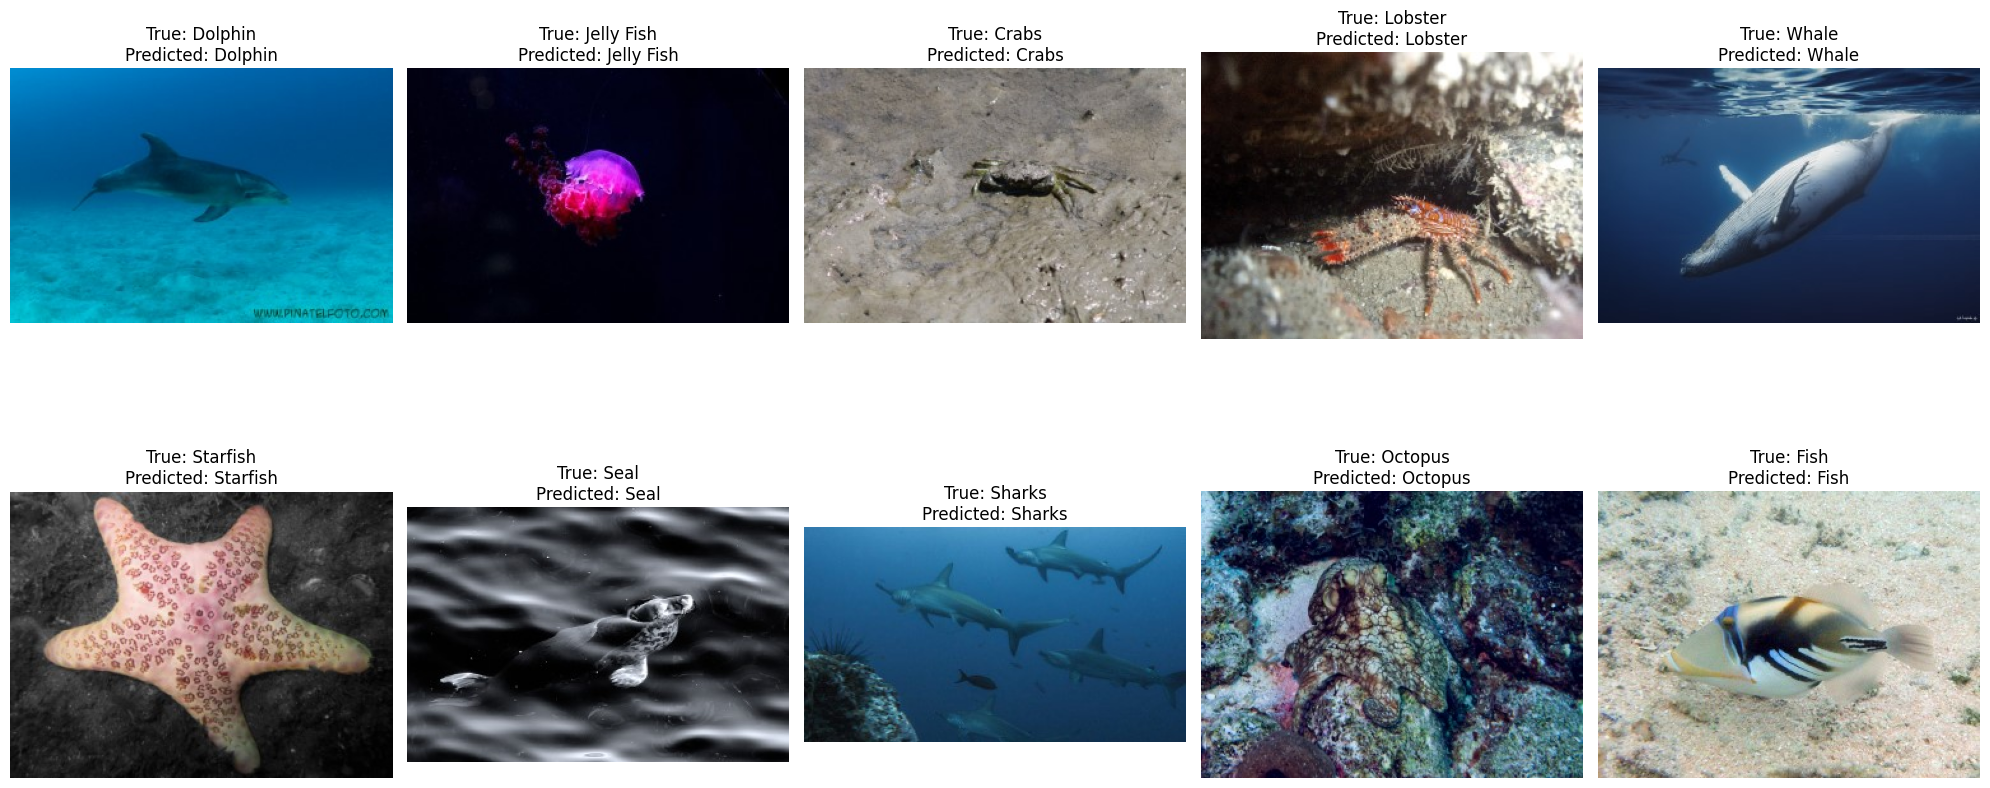

In [ ]:
# Initialize WandB for test visualization
wandb.init(
    project="DSAI544-Final",
    name="2/Test Results Visualization"
)

# Test images directory (update to split dataset's test directory)
test_images_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/test'

# Transform for the test images (resize and normalization only, no augmentations)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Randomly select 10 test images from the test dataset
selected_images = []
for class_name in os.listdir(test_images_dir):
    class_dir = os.path.join(test_images_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        selected_images += [(class_name, os.path.join(class_dir, img)) for img in random.sample(image_files, 1)]

# Prepare test images and ground truth labels
test_images = []
true_labels = []
for class_name, img_path in selected_images:
    img = Image.open(img_path).convert("RGB")  # Ensure it's in RGB mode
    img = test_transform(img)
    test_images.append(img)
    true_labels.append(class_name)

# Stack images into a batch
test_images = torch.stack(test_images)  # Combine into a single batch
device = "cuda" if torch.cuda.is_available() else "cpu"
test_images = test_images.to(device)

# Set model to evaluation mode
model_resnet50_pretrained.to(device)
model_resnet50_pretrained.eval()

# Predict classes
with torch.no_grad():
    outputs = model_resnet50_pretrained(test_images)
    predicted_classes = outputs.argmax(dim=1).tolist()

# Map predicted class indices to class names
class_names = train_dataset.classes  # Use train dataset to map class names
predicted_labels = [class_names[idx] for idx in predicted_classes]

# Prepare WandB images
wandb_images = []
for true_label, predicted_label, img_path in zip(true_labels, predicted_labels, selected_images):
    img = Image.open(img_path[1])  # Load the image
    wandb_images.append(
        wandb.Image(img.resize((128, 128)), caption=f"True: {true_label}, Predicted: {predicted_label}")
    )

# Log all images to WandB
wandb.log({"Test Results": wandb_images})

# Display the images locally as well
plt.figure(figsize=(20, 10))
for i, (true_label, predicted_label, img_path) in enumerate(zip(true_labels, predicted_labels, selected_images)):
    plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
    img = Image.open(img_path[1])
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Finish WandB session
wandb.finish()

##Testing-2

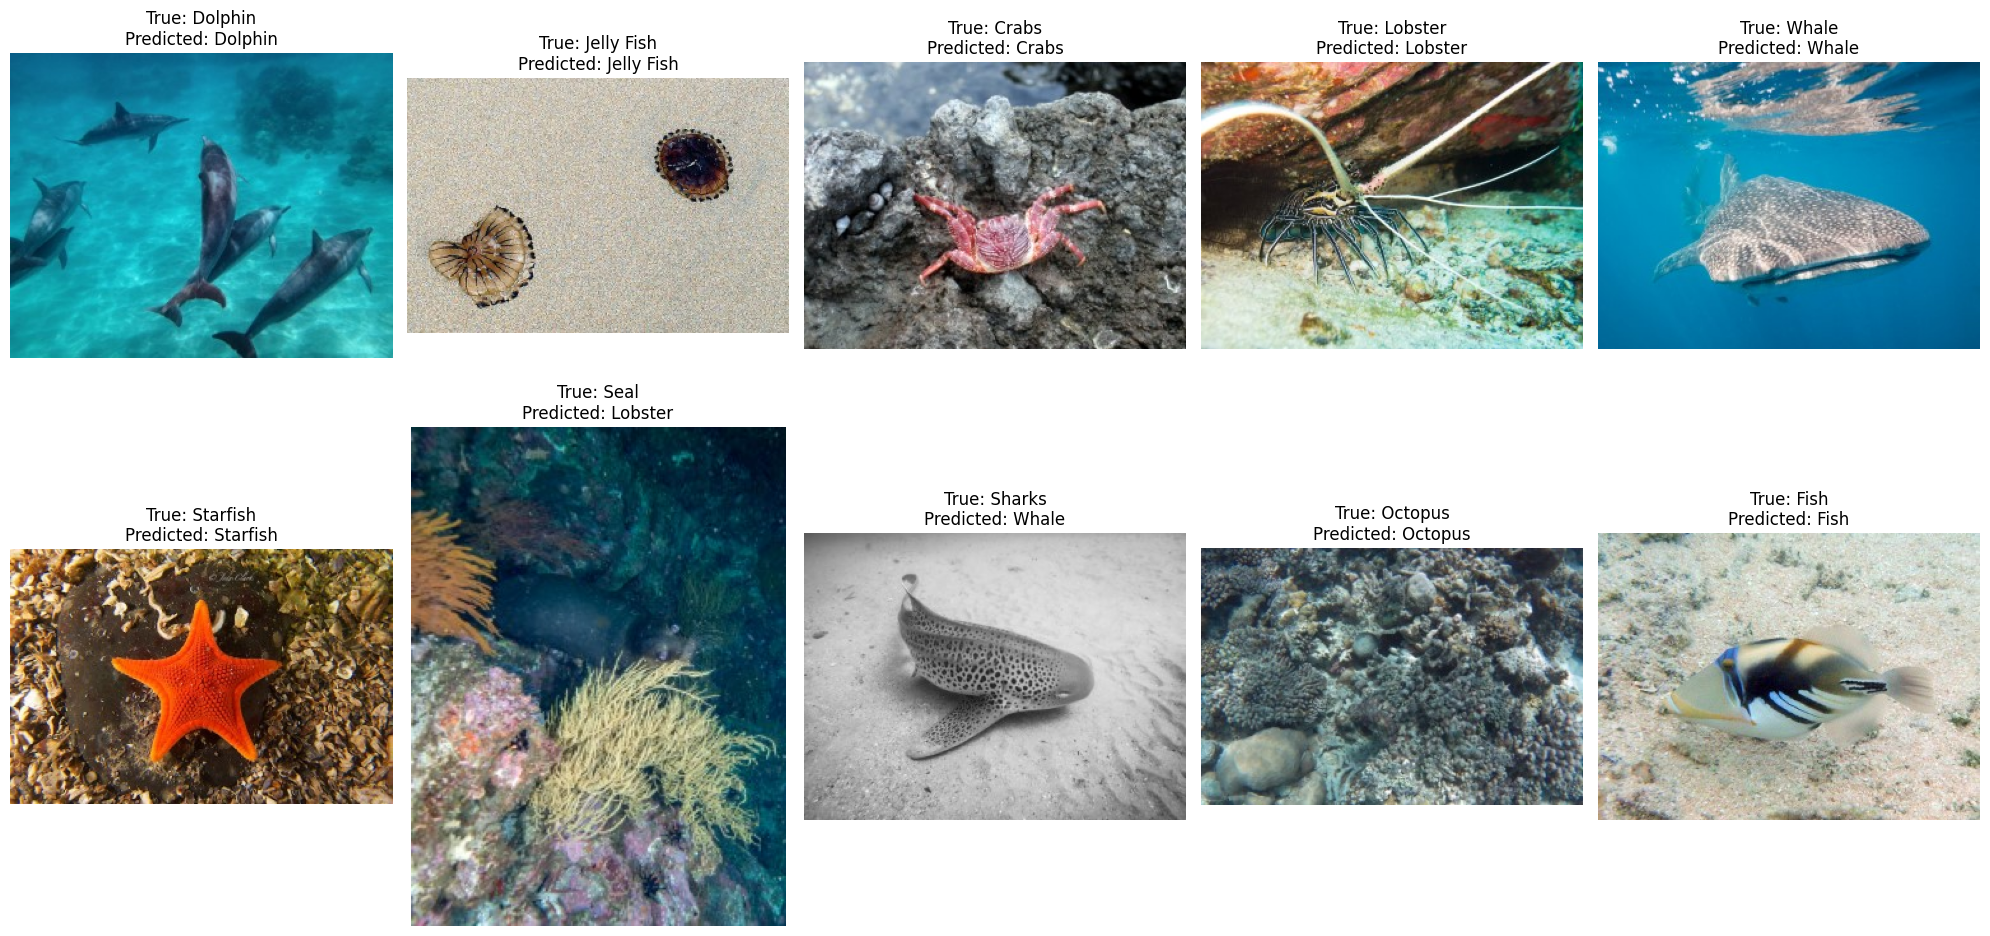

In [ ]:
# Initialize WandB for test visualization
wandb.init(
    project="DSAI544-Final",
    name="2/Test Results Visualization"
)

# Test images directory (update to split dataset's test directory)
test_images_dir = '/content/drive/MyDrive/DSAI544_Final/split_dataset/test'

# Transform for the test images (resize and normalization only, no augmentations)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Randomly select 10 test images from the test dataset
selected_images = []
for class_name in os.listdir(test_images_dir):
    class_dir = os.path.join(test_images_dir, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        selected_images += [(class_name, os.path.join(class_dir, img)) for img in random.sample(image_files, 1)]

# Prepare test images and ground truth labels
test_images = []
true_labels = []
for class_name, img_path in selected_images:
    img = Image.open(img_path).convert("RGB")  # Ensure it's in RGB mode
    img = test_transform(img)
    test_images.append(img)
    true_labels.append(class_name)

# Stack images into a batch
test_images = torch.stack(test_images)  # Combine into a single batch
device = "cuda" if torch.cuda.is_available() else "cpu"
test_images = test_images.to(device)

# Set model to evaluation mode
model_resnet50_2.to(device)
model_resnet50_2.eval()

# Predict classes
with torch.no_grad():
    outputs = model_resnet50_pretrained(test_images)
    predicted_classes = outputs.argmax(dim=1).tolist()

# Map predicted class indices to class names
class_names = train_dataset.classes  # Use train dataset to map class names
predicted_labels = [class_names[idx] for idx in predicted_classes]

# Prepare WandB images
wandb_images = []
for true_label, predicted_label, img_path in zip(true_labels, predicted_labels, selected_images):
    img = Image.open(img_path[1])  # Load the image
    wandb_images.append(
        wandb.Image(img.resize((128, 128)), caption=f"True: {true_label}, Predicted: {predicted_label}")
    )

# Log all images to WandB
wandb.log({"Test Results": wandb_images})

# Display the images locally as well
plt.figure(figsize=(20, 10))
for i, (true_label, predicted_label, img_path) in enumerate(zip(true_labels, predicted_labels, selected_images)):
    plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
    img = Image.open(img_path[1])
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Finish WandB session
wandb.finish()